# Projeto Final de Machine Learning

<strong>Membros:</strong>
- João Laet
- Nicolas Cho
- Roger Pina

<strong>Professor:</strong>
- Fábio Ayres

<strong>Github:</strong>
- https://github.com/NicolasCho/projeto_ML

<strong>Dataset:</strong>
- https://www.kaggle.com/competitions/mens-machine-learning-competition-2018/data

## Sumário

* [1 - Introdução](#1)
* [2 - Imports](#2)
* [3 - Data Exploration](#3)
* [4 - Feature Engineering](#4)
* [5 - Data Visualization](#5)
* [6 - Models](#6)
* [7 - Resultados](#7)
* [8 - Conclusão](#8)

<a name="1"></a>
## 1 - Introdução

Projeto tem como objetivo o desenvolvimento de um modelo preditivo para prever o resultado de jogos da NCAA, liga universitária americana de basquete, dados os times participantes.

---

<a name="2"></a>
## 2 - Imports

In [ ]:
import math
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import os
from sklearn.metrics import (mean_squared_error,
                             confusion_matrix,  # ConfusionMatrixDisplay,
                             roc_curve, roc_auc_score)
from sklearn import tree
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from plotnine import *
#from keras import tensorflow

---

<a name="3"></a>
## 3 - Data Exploration

Das tabelas disponíveis, foram selecionadas as que contém informações dos ID's e nomes de todos os times participantes além das que possuem os detalhes dos jogos que já ocorreram desde 1985.

### Data Section 1 - The basics

In [ ]:
os.chdir("data/NCAA/")

In [ ]:
df_teams = pd.read_csv("Teams.csv")
seasons = pd.read_csv("Seasons.csv")
NCAATourneySeeds = pd.read_csv("NCAATourneySeeds.csv")
RegularSeasonCompactResults = pd.read_csv("RegularSeasonCompactResults.csv")
NCAATourneyCompactResults = pd.read_csv("NCAATourneyCompactResults.csv")
SampleSubmissionStage1 = pd.read_csv("SampleSubmissionStage1.csv")

### Teams

In [ ]:
df_teams

### Seasons

In [ ]:
seasons

### Seeds

In [ ]:
NCAATourneySeeds

In [ ]:
NCAATourneySeeds = NCAATourneySeeds[NCAATourneySeeds['Season'] < 2014]

### RegularSeasonCompactResults

In [ ]:
RegularSeasonCompactResults

In [ ]:
RegularSeasonCompactResults = RegularSeasonCompactResults[RegularSeasonCompactResults['Season'] < 2014]

### NCAATourneyCompactResults

In [ ]:
NCAATourneyCompactResults 

In [ ]:
NCAATourneyCompactResults = NCAATourneyCompactResults[NCAATourneyCompactResults['Season'] < 2014]

Existem duas tabelas com os jogos, sendo elas:

<strong>1 - RegularSeason</strong>
Campeonato antes da NCAA - 150K linhas de jogos (1985 - 2017)

<strong>2 - NCAA Tourney</strong>
2K linhas de jogos (1985 - 2017)

### SampleSubmissionStage1

In [ ]:
SampleSubmissionStage1

In [ ]:
#pbp2010 = pd.read_csv('./mens-machine-learning-competition-2018/PlayByPlay_2010/Events_2010.csv')

---

<a name="4"></a>
## 4 - Feature Engineering e Elo Rating

Antes de iniciar modelos, devemos preparar os dados e extrair as informações importantes que serão usadas.

### Elo Rating

O elo é um sistema criado para medir a "força" de um time. Para tanto, atribui-se um score para cada time que aumenta ou diminui conforme ele ganha e perde partidas, respectivamente. O cálculo do elo foi baseado no seguinte artigo:

https://fivethirtyeight.com/features/how-we-calculate-nba-elo-ratings/#:~:text=Here's%20the%20formula%3A%20Take%20the,and%20then%20divide%20by%2028

In [ ]:
# Calcula as probabilidades de cada time em uma partida ganhar
def win_probs(wTeam_elo, lTeam_elo, home_court_advantage, WLoc):
    w = math.pow(10, wTeam_elo/400)
    l = math.pow(10, lTeam_elo/400)
    a = math.pow(10, home_court_advantage/400) 
    
    if WLoc == 'H':
        denom = l + a*w
        wTeam_prob = a*w / denom
        lTeam_prob = l / denom   
        
    elif WLoc == 'A':
        denom = a*l + w
        wTeam_prob = w / denom
        lTeam_prob = a*l / denom   
        
    else:
        denom = l + w
        wTeam_prob = a / denom
        lTeam_prob = l / denom 
        
    return wTeam_prob, lTeam_prob

In [ ]:
# Determina o quão forte será a mudança de elo dado resultado de uma partida
def elo_k(MOV, elo_diff):
    k = 20
    if MOV>0:
        multiplier=(MOV+3)**(0.8)/(7.5+0.006*(elo_diff))
    else:
        multiplier=(-MOV+3)**(0.8)/(7.5+0.006*(-elo_diff))
    return k*multiplier

In [ ]:
# Atualiza o elo de cada time conforme o resultado de uma partida
def update_elo(game, df_eloActual):
    home_court_advantage = 100
    wTeam = game['WTeamID']
    wTeam_elo = int(df_eloActual[df_eloActual['TeamID'] == wTeam][str(game['Season'])])
    wTeam_score = game['WScore']
    #print(wTeam, wTeam_elo, wTeam_score)
    
    lTeam = game['LTeamID']
    lTeam_elo = int(df_eloActual[df_eloActual['TeamID'] == lTeam][str(game['Season'])])
    lTeam_score = game['LScore']
    #print(lTeam, lTeam_elo, lTeam_score)
        
    wTeam_prob, lTeam_prob = win_probs(wTeam_elo, lTeam_elo, home_court_advantage, game['WLoc'])
    
    k = elo_k(wTeam_score - lTeam_score, wTeam_elo - lTeam_elo)
        
    updated_wTeam_elo = wTeam_elo + k * (1 - wTeam_prob) 
    updated_lTeam_elo = lTeam_elo + k * (0 - lTeam_prob)
    
    return updated_wTeam_elo, updated_lTeam_elo

In [ ]:
# 1
df_RegularSeason = RegularSeasonCompactResults.copy() # Dataframe que será adicinado o elo rating

# 2 
df_NCAATourney = NCAATourneyCompactResults.copy() # Dataframe que será adicinado o elo rating

In [ ]:
df_elo = df_teams.copy().drop(columns=['TeamName', 'FirstD1Season', 'LastD1Season'])

for season in df_NCAATourney['Season'].unique():

  if season == 1985:
    df_elo[str(season)] = 1500
  else:
    df_elo[str(season)] = list(df_elo[str(season - 1)])

  #1 - Calcular o Elo Rating na Regular Season
  for index, row in df_RegularSeason[df_RegularSeason['Season'] == season].iterrows():
    updated_wTeam_elo, updated_lTeam_elo = update_elo(row, df_elo)

    #wTeam
    idx = df_elo[df_elo['TeamID'] == row['WTeamID']].index[0]
    df_elo.loc[idx, str(season)] = updated_wTeam_elo
    df_RegularSeason.loc[index, 'WElo'] = updated_wTeam_elo
    
    #lTeam
    idx = df_elo[df_elo['TeamID'] == row['LTeamID']].index[0]
    df_elo.loc[idx, str(season)] = updated_lTeam_elo
    df_RegularSeason.loc[index, 'LElo'] = updated_lTeam_elo 

  #2 - Calcular o Elo Rating no NCAA
  for index, row in df_NCAATourney[df_NCAATourney['Season'] == season].iterrows():
    updated_wTeam_elo, updated_lTeam_elo = update_elo(row, df_elo)

    #wTeam
    idx = df_elo[df_elo['TeamID'] == row['WTeamID']].index[0]
    df_elo.loc[idx, str(season)] = updated_wTeam_elo
    df_NCAATourney.loc[index, 'WElo'] = updated_wTeam_elo
    
    #lTeam
    idx = df_elo[df_elo['TeamID'] == row['LTeamID']].index[0]
    df_elo.loc[idx, str(season)] = updated_lTeam_elo
    df_NCAATourney.loc[index, 'LElo'] = updated_lTeam_elo 

### Tabela final para modelo

Tendo o histórico de partidas e os elos associados aos times para cada determinado momento, é possível reduzir os dados a serem utilizados em uma tabela final.

In [ ]:
df_RegularSeason['Tourney'] = 'RS'
df_NCAATourney['Tourney'] = 'NCAA'

In [ ]:
AllGames = pd.concat([df_RegularSeason ,df_NCAATourney])
AllGames['TeamA'] = AllGames[["WTeamID", "LTeamID"]].min(axis=1)
AllGames['TeamB'] = AllGames[["WTeamID", "LTeamID"]].max(axis=1)
AllGames['Mandante'] = np.where(AllGames['WLoc'] == "H", AllGames['WTeamID'],
                           np.where(AllGames['WLoc'] == "A", AllGames['LTeamID'], "0"))
AllGames['TeamAWins'] = np.where(AllGames['WTeamID'] == AllGames['TeamA'], True, False)
AllGames['EloA'] = np.where(AllGames['TeamA'] == AllGames['WTeamID'], AllGames['WElo'], AllGames['LElo'])
AllGames['EloB'] = np.where(AllGames['TeamB'] == AllGames['LTeamID'], AllGames['LElo'], AllGames['WElo'])
AllGames

In [ ]:
#Cria csv ta tabela acima
AllGames.to_csv("games_with_elo.csv", index = False)

In [ ]:
AllGames = pd.read_csv("games_with_elo.csv")

In [ ]:
#AllGames

In [ ]:
df = pd.DataFrame()
df['Season'] = AllGames['Season']
df['TeamA'] = AllGames['TeamA']
df['TeamB'] = AllGames['TeamB']
df['Mandante'] = AllGames['Mandante']
df['EloA'] = AllGames['EloA']
df['EloB'] = AllGames['EloB']
df['TeamAWins'] = AllGames['TeamAWins']
df

---

<a name="5"></a>
## 5 - Data Visualization

Para uma análise visual mais direta e inicial dos dados obtidos, será calculada a probabilidade de vitória de um time sobre outro time baseada no histórico de partidas que esses dois times já disputaram juntos. 

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
visualizacao = df.loc[df['TeamAWins'] == True].groupby(['TeamA','TeamB'])['TeamAWins'].count() / df.groupby(['TeamA','TeamB'])['TeamAWins'].count()
visualizacao = visualizacao.reset_index()
visualizacao = visualizacao.fillna(0)
visualizacao

Da tabela acima, temos a probabilidade do time A ganhar do time B.

In [ ]:
plt.scatter(visualizacao["TeamA"], visualizacao["TeamB"], c= visualizacao["TeamAWins"], cmap=plt.cm.autumn, alpha=0.5, s = 1)
plt.title("Probabilidade de vitória do time A contra time B")
plt.xlabel("Time A")
plt.ylabel("Time B")
plt.show()

Já o gráfico acima mostra as probabilidades dos times em A (eixo x), ganharem dos times em B (eixo y). Cores mais fortes significam maiores
probabilidades de vitórias e cores mais fracas significam menores probabilidades.

Removendo pontos "seguros" (com taxa de vitória ou derrota altas)

In [ ]:
visualizacao_incertos = visualizacao.loc[(visualizacao.TeamAWins > 0.4) & (visualizacao.TeamAWins < 0.6)]
visualizacao_incertos

In [ ]:
plt.scatter(visualizacao_incertos["TeamA"], visualizacao_incertos["TeamB"], c= visualizacao_incertos["TeamAWins"], cmap=plt.cm.autumn, alpha=1, s = 1)
plt.title("Probabilidade de vitória do time A contra time B (maiores incertezas)")
plt.xlabel("Time A")
plt.ylabel("Time B")
plt.show()

O gráfico acima mostra apenas os pontos em que há grande incerteza de resultado (probabilidade de vitória entre 40% e 60%). É possível observar que utilizando o método descrito para o cálculo das probabilidades, há muitos pontos incertos no gráfico. 

---

<a name="6"></a>
## 6 - Models

### Previsão utilizando matriz de transição

A primeira ideia desenvolvida seria utilizando justamente as probabilidades obtidas na seção anterior e criar uma matriz de transição entre os times presentes.

No caso, surgiria um problema: nem todos os jogos possíveis entre todos os times já ocorreram na base de dados. Logo, nosso modelo não possuíria informação para alguns confrontos e, portanto, não seria capaz de estimar o resultado.

Como solução, sería possível criar uma rede de todos os times em que as arestas seriam as probabilidades de um time ganhar de outro (sempre do menor ID para o maior). Assim, caso não exista histórico entre dois times, é possível calcular a probabilidade utilizando um caminho na rede.

#### Criando a rede

In [ ]:
import networkx as nx

G = nx.from_pandas_edgelist(visualizacao, source='TeamA', target='TeamB',
                            edge_attr='TeamAWins') 

In [ ]:
visualizacao_copy = visualizacao.copy()
teams = pd.unique(visualizacao_copy[['TeamA', 'TeamB']].values.ravel('K'))
n = len(teams)
n

In [ ]:
len(df_teams)

4 times não apareceram em nenhuma partida até 2014

#### Matriz de transição

In [ ]:
matrix = np.zeros((n,n))

In [ ]:
trans_matrix = pd.DataFrame(matrix, columns = teams, index=teams)

In [ ]:
trans_matrix

No caso, será utilizado o menor caminho na rede, entre dois times, para calcular a probabilidade.

In [ ]:
#Todos os caminhos minimos possiveis entre possibilidades de jogos
erros = 0
i = 0
for team in teams[:]:
    for opponent in teams[i+1:]:
        try:
            probability = 1
            path = nx.shortest_path(G, source=team, target=opponent)
            for source, target in zip(path, path[1:]):
                prob = G[source][target]["TeamAWins"]
                if source < target:
                    probability *= prob
                else:
                    probability *= (1 - prob)
            trans_matrix.loc[trans_matrix.index == path[0], path[-1]] = prob
        except:
            erros += 1 
    i += 1
print(erros)

In [ ]:
trans_matrix

A visualização da rede pode ser feita rodando a célula abaixo (alterando os valores dos argumentos para melhor visualização)

In [ ]:
# widths = np.array([w for *_, w in G.edges.data('TeamAWins')])

# pos = nx.spring_layout(G, seed=7)  # positions for all nodes - seed for reproducibi

# # nodes
# nx.draw_networkx_nodes(G, pos)

# # edges
# nx.draw_networkx_edges(G, pos, width=widths)  

# # labels
# nx.draw_networkx_labels(G, pos, font_family="sans-serif")

# ax = plt.gca()
# ax.margins(0.08)
# plt.axis("off")
# plt.tight_layout()

### Previsão utilizando outros modelos e elo rating

Além do modelo utilizando matriz de transição, podemos utilizar de modelos mais clássicos de Machine Learning e da variável de Elo Rating calculada nas sessões anteriores.

Será necessário separar entre dados de treino e teste

In [ ]:
df1 = df.drop(columns=['Mandante', "Season"])
df1[['TeamA','TeamB']] = df[['TeamA','TeamB']].astype(str)

In [ ]:
from sklearn.linear_model import LogisticRegression
RANDOM_SEED = 42
train_set, test_set = train_test_split(
    df1,
    test_size=0.2,
    random_state=RANDOM_SEED,
)

X_train = train_set.drop(columns=['TeamAWins'])
y_train = train_set['TeamAWins']

X_test = test_set.drop(columns=['TeamAWins'])
y_test = test_set['TeamAWins']

#### Logistic regression

Como queremos classificar se o time A ganha do time B, é possíve utilizar um modelo de regressão logística (classificação) para prever os resultados.

In [ ]:
rl = LogisticRegression()
rl.fit(X_train, y_train)
y_pred_rl = rl.predict(X_test)

In [ ]:
CM_RL = confusion_matrix(y_test, y_pred_rl)
print(CM_RL, "\n")

accuracy = (CM_RL[0, 0] + CM_RL[1, 1]) / CM_RL.sum()
print(f"Accuracy:    {accuracy:.4f}")

sensitivity = CM_RL[1, 1] / (CM_RL[1, 0] + CM_RL[1, 1])
print(f"Sensitivity: {sensitivity:.4f}")

specificity = CM_RL[0, 1] / (CM_RL[0, 0] + CM_RL[0, 1])
print(f"Specificity: {specificity:.4f}")

#### Random Forest

Outro modelo que pode ser utilizado é o de Random Forest.

In [ ]:
rf = RandomForestClassifier(random_state = 42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [ ]:
CM_RF = confusion_matrix(y_test, y_pred_rf)
print(CM_RF, "\n")

accuracy = (CM_RF[0, 0] + CM_RF[1, 1]) / CM_RF.sum()
print(f"Accuracy:    {accuracy:.4f}")

sensitivity = CM_RF[1, 1] / (CM_RF[1, 0] + CM_RF[1, 1])
print(f"Sensitivity: {sensitivity:.4f}")

specificity = CM_RF[0, 1] / (CM_RF[0, 0] + CM_RF[0, 1])
print(f"Specificity: {specificity:.4f}")

#### Decision Tree

Por fim, árvores de decisão também podem ser utilizadas em problemas de classificação.

In [ ]:
dt = tree.DecisionTreeClassifier(random_state = 42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

In [ ]:
CM_DT = confusion_matrix(y_test, y_pred_dt)
print(CM_DT, "\n")

accuracy = (CM_DT[0, 0] + CM_DT[1, 1]) / CM_DT.sum()
print(f"Accuracy:    {accuracy:.4f}")

sensitivity = CM_DT[1, 1] / (CM_DT[1, 0] + CM_DT[1, 1])
print(f"Sensitivity: {sensitivity:.4f}")

specificity = CM_DT[0, 1] / (CM_DT[0, 0] + CM_DT[0, 1])
print(f"Specificity: {specificity:.4f}")

### Machine learning com dados de mandante

Os modelos acima utilizaram apenas da variável de elo rating para determinar a probabilidade de vitória. Pelos dados fornecidos, também é possível utilizar do fato do time estar jogando em casa ou não para auxiliar na previsão do modelo. A variável está na coluna de "Mandante".

In [ ]:
df2 = df.drop(columns=["Season"])
df2[['TeamA','TeamB',"Mandante"]] = df[['TeamA','TeamB',"Mandante"]].astype(str)
df2

In [ ]:
train_setM, test_setM = train_test_split(
    df2,
    test_size=0.2,
    random_state=RANDOM_SEED,
)

X_trainM = train_setM.drop(columns=['TeamAWins'])
y_trainM = train_setM['TeamAWins']

X_testM = test_setM.drop(columns=['TeamAWins'])
y_testM = test_setM['TeamAWins']

In [ ]:
X_trainM

#### Regressão Logística

In [ ]:
rlM = LogisticRegression()
rlM.fit(X_trainM, y_trainM)
y_pred_rlM = rlM.predict(X_testM)

CM_RLM = confusion_matrix(y_testM, y_pred_rlM)
print(CM_RLM, "\n")

accuracy = (CM_RLM[0, 0] + CM_RLM[1, 1]) / CM_RLM.sum()
print(f"Accuracy:    {accuracy:.4f}")

sensitivity = CM_RLM[1, 1] / (CM_RLM[1, 0] + CM_RLM[1, 1])
print(f"Sensitivity: {sensitivity:.4f}")

specificity = CM_RLM[0, 1] / (CM_RLM[0, 0] + CM_RLM[0, 1])
print(f"Specificity: {specificity:.4f}")

#### Random Forest

In [ ]:
rfM = RandomForestClassifier(random_state = 42)
rfM.fit(X_trainM, y_trainM)
y_pred_rfM = rfM.predict(X_testM)

CM_RFM = confusion_matrix(y_testM, y_pred_rfM)
print(CM_RFM, "\n")

accuracy = (CM_RFM[0, 0] + CM_RFM[1, 1]) / CM_RFM.sum()
print(f"Accuracy:    {accuracy:.4f}")

sensitivity = CM_RFM[1, 1] / (CM_RFM[1, 0] + CM_RFM[1, 1])
print(f"Sensitivity: {sensitivity:.4f}")

specificity = CM_RFM[0, 1] / (CM_RFM[0, 0] + CM_RFM[0, 1])
print(f"Specificity: {specificity:.4f}")

#### Decision Tree

In [ ]:
dtM = tree.DecisionTreeClassifier(random_state = 42)
dtM.fit(X_trainM, y_trainM)
y_pred_dtM = dtM.predict(X_testM)

CM_DTM = confusion_matrix(y_testM, y_pred_dtM)
print(CM_DTM, "\n")

accuracy = (CM_DTM[0, 0] + CM_DTM[1, 1]) / CM_DTM.sum()
print(f"Accuracy:    {accuracy:.4f}")

sensitivity = CM_DTM[1, 1] / (CM_DTM[1, 0] + CM_DTM[1, 1])
print(f"Sensitivity: {sensitivity:.4f}")

specificity = CM_DTM[0, 1] / (CM_DTM[0, 0] + CM_DTM[0, 1])
print(f"Specificity: {specificity:.4f}")

---

<a name="7"></a>
## 7 - Resultados

### Modelos com elo rating

Utilizando a variável de elo rating e dado de mandante, obtemos a seguinte tabela com as performances de cada modelo

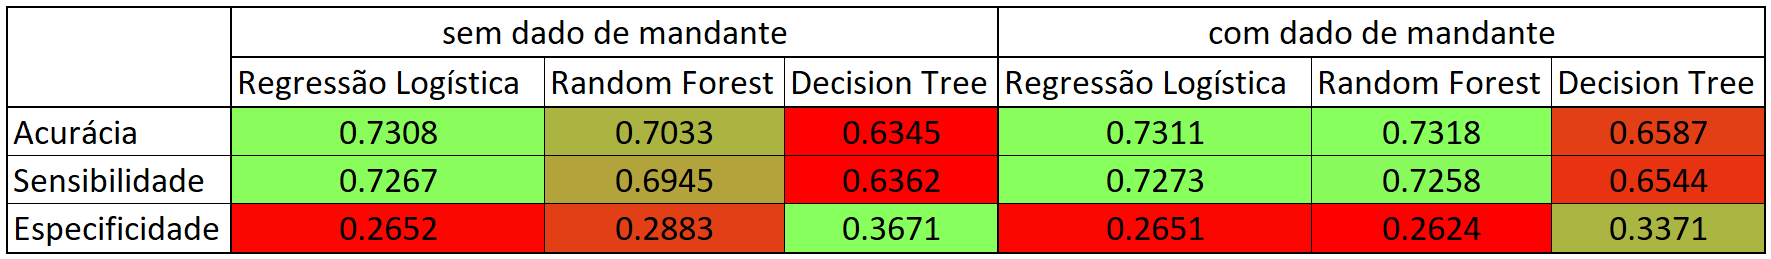

As curvas ROC para cada modelo da tabela acima também podem ser obtidas:

In [ ]:
y_pred_prob_rl = rl.predict_proba(X_test)
y_pred_prob_rl = y_pred_prob_rl[:, 1]

y_pred_prob_rf = rf.predict_proba(X_test)
y_pred_prob_rf = y_pred_prob_rf[:, 1]

y_pred_prob_dt = dt.predict_proba(X_test)
y_pred_prob_dt = y_pred_prob_dt[:, 1]


y_pred_prob_rlM = rlM.predict_proba(X_testM)
y_pred_prob_rlM = y_pred_prob_rlM[:, 1]

y_pred_prob_rfM = rfM.predict_proba(X_testM)
y_pred_prob_rfM = y_pred_prob_rfM[:, 1]

y_pred_prob_dtM = dtM.predict_proba(X_testM)
y_pred_prob_dtM = y_pred_prob_dtM[:, 1]

In [ ]:
fpr_rl, tpr_rl, thresholds_rl = roc_curve(y_test, y_pred_prob_rl)
print(f"AUC score regressão logística:    {roc_auc_score(y_test, y_pred_prob_rl):.4f}")

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_prob_rf)
print(f"AUC score random forest:    {roc_auc_score(y_test, y_pred_prob_rf):.4f}")

fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_pred_prob_dt)
print(f"AUC score decision tree:    {roc_auc_score(y_test, y_pred_prob_dt):.4f}")


fpr_rlM, tpr_rlM, thresholds_rlM = roc_curve(y_testM, y_pred_prob_rlM)
print(f"AUC score regressão logística com mandante:    {roc_auc_score(y_testM, y_pred_prob_rlM):.4f}")

fpr_rfM, tpr_rfM, thresholds_rfM = roc_curve(y_testM, y_pred_prob_rfM)
print(f"AUC score random forest com mandante:    {roc_auc_score(y_testM, y_pred_prob_rfM):.4f}")

fpr_dtM, tpr_dtM, thresholds_dtM = roc_curve(y_testM, y_pred_prob_dtM)
print(f"AUC score decision tree com mandante:    {roc_auc_score(y_testM, y_pred_prob_dtM):.4f}")

In [ ]:
(pd.concat([pd.DataFrame(dict(fpr = fpr_rl, tpr = tpr_rl, model = "Logistic regression")),
            pd.DataFrame(dict(fpr = fpr_dt, tpr = tpr_dt, model = "Classification tree")), 
            pd.DataFrame(dict(fpr = fpr_rf,   tpr = tpr_rf,   model = "Random Forest")),
            pd.DataFrame(dict(fpr = fpr_rlM, tpr = tpr_rlM, model = "Logistic regression com Mandante")),
            pd.DataFrame(dict(fpr = fpr_dtM, tpr = tpr_dtM, model = "Classification tree com Mandante")),
            pd.DataFrame(dict(fpr = fpr_rfM,   tpr = tpr_rfM,   model = "Random Forest com Mandante"))])
   .pipe(lambda _: ggplot(_, aes(x = "fpr", y = "tpr", color = "model")) +
                       geom_line(size = 1) + 
                       geom_abline(linetype = "dashed") +
                       labs(x = "FPR (1 -  Specificity)", y = "TPR (Sensitivity)",
                            title = "ROC Curve") +
                       theme(legend_title = element_blank())))

---

### Utilizando a matriz de transição

Para medir o desempenho utilizando a matriz de transição será necessário utilizar novos dados que não foram utilizados para o "treinamento" (cálculo das probabilidades) do modelo.

Serão utilizados os jogos de 2014 teste da matriz de transição

In [ ]:
RegularSeasonCompactResults = pd.read_csv("RegularSeasonCompactResults.csv")

In [ ]:
RegularSeasonCompactResults_2014 = RegularSeasonCompactResults[RegularSeasonCompactResults['Season'] == 2014]
RegularSeasonCompactResults_2014

In [ ]:
RegularSeasonCompactResults_2014['TeamA'] = RegularSeasonCompactResults_2014[["WTeamID", "LTeamID"]].min(axis=1)
RegularSeasonCompactResults_2014['TeamB'] = RegularSeasonCompactResults_2014[["WTeamID", "LTeamID"]].max(axis=1)
RegularSeasonCompactResults_2014['TeamAWins'] = np.where(RegularSeasonCompactResults_2014['WTeamID'] == RegularSeasonCompactResults_2014['TeamA'], True, False)
RegularSeasonCompactResults_2014 = RegularSeasonCompactResults_2014.drop(columns=['DayNum', "Season", "WScore", "LTeamID", "LScore", "WLoc", "NumOT", "WTeamID"])
RegularSeasonCompactResults_2014['pred'] = False
RegularSeasonCompactResults_2014

Acima temos a tabela coms os jogos de 2014 e as colunas **TeamAWins** (indica se o time A ganhou) e **pred** (previsão do modelo). **pred** é inicializada com False em todas as linhas

Utilizando a matriz para deteriminar as probabilidades:

In [ ]:
for index, row in RegularSeasonCompactResults_2014.iterrows():
    try:
        val =  trans_matrix.loc[trans_matrix.index == int(row['TeamA']), int(row['TeamB'])].values[0] > 0.5
    except:
        val = False         
    RegularSeasonCompactResults_2014.loc[(RegularSeasonCompactResults_2014['TeamA'] == row['TeamA'])&(RegularSeasonCompactResults_2014['TeamB'] == RegularSeasonCompactResults_2014['TeamB']), 'pred'] = val

In [ ]:
RegularSeasonCompactResults_2014

Desempenho da matriz:

In [ ]:
acertos = 0
total = RegularSeasonCompactResults_2014.shape[0]
for index, row in RegularSeasonCompactResults_2014.iterrows():
    if row['TeamAWins'] == row['pred']:
        acertos += 1
acc = acertos / total
acc

---

<a name="8"></a>
## 8 - Conclusão

Para as previsões utilizando a matriz de transição, obtivemos um resultado ruim, com uma acurácia de aproximadamente 54%. Tal desempenho pode ter sido causado pelo fato de não possuirmos dados significativos o suficiente de todos os confrontos entre dois times. Ou seja, pelo fato de dois times possuírem poucos confrontos na base de dados, é difícil determinar a probabilidade de um time ganhar baseado nessa pouca quantidade de jogos jogados entre os dois. Além disso, a grande quantidade de incerteza, como visto nos gráficos de visualização, também podem contribuir para um desempenho ruim.

## Falar do desempenho dos outros modelos aqui!